<a href="https://colab.research.google.com/github/aashwinmishra/ProbabilisticCoherentDiffractionImaging/blob/main/notebooks/ProbabilisticCoherentDiffractionImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
from google.colab import files

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
H, W = 64, 64
NLINES = 100
NLTEST = 60
N_VALID = 805

In [3]:
def process_data(diffraction_data: str, real_data: str, NLINES: int, H: int, W: int) -> tuple:
  """
  Takes links for the diffraction and real data files, processes them and
  returns numpy arrays for diffraction data (input) and outputs of real-space
  amplitude and phase.
  Args:
    diffraction_data: path to diffraction data file
    real_data: path to real space data file
    NLINES: Number of lines of scanned data to use for train set
    H: Height of images
    W: Width of images
  Returns:
    tuple of (X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test)
  """
  data_diffr = np.load(diffraction_data)['arr_0']
  real_space = np.load(real_data)
  amp, ph = np.abs(real_space), np.angle(real_space)

  data_diffr_red = np.zeros((data_diffr.shape[0], data_diffr.shape[1], 64, 64), float)
  for i in range(data_diffr.shape[0]):
    for j in range(data_diffr.shape[1]):
      data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
      data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

  tst_strt = amp.shape[0]-NLTEST #Where to index from
  X_train = data_diffr_red[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
  X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
  Y_I_train = amp[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
  Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]
  Y_phi_train = ph[:NLINES,:].reshape(-1,H,W)[:,np.newaxis,:,:]
  Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,H,W)[:,np.newaxis,:,:]

  X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)
  return X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test

In [11]:
def get_dataloaders(data_path, val_num: int=805, batch_size: int=64, num_workers: int=2)->dict:
  """
  Generates train, validation and test dataloaders from the raw numpy files.
  Args:
    data_path: Location of raw numpy files
    val_num: Number of lines of scan to be saved as validation data
    batch_size: uniform batch size
    num_workers: number of data loader worker processes
  Returns:
    Dict of {"train_dl": train_dl, "val_dl": val_dl, "test_dl": test_dl}
  """
  X_train, Y_I_train, Y_phi_train = torch.from_numpy(np.load(data_path+"X_train.npy")).to(torch.float), torch.from_numpy(np.load(data_path+"Y_I_train.npy")), torch.from_numpy(np.load(data_path+"Y_phi_train.npy"))
  X_test, Y_I_test, Y_phi_test = torch.from_numpy(np.load(data_path+"X_test.npy")).to(torch.float), torch.from_numpy(np.load(data_path+"Y_I_test.npy")), torch.from_numpy(np.load(data_path+"Y_phi_test.npy"))
  train_data_init = TensorDataset(X_train, Y_I_train, Y_phi_train)
  test_dataset = TensorDataset(X_test, Y_I_test, Y_phi_test)
  train_dataset, val_dataset = random_split(train_data_init, [X_train.shape[0]-val_num, val_num])

  train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  return {"train_dl": train_dl, "val_dl": val_dl, "test_dl": test_dl}

In [12]:
d = get_dataloaders("./gdrive/MyDrive/PtychoNNData/")
train_dl = d["train_dl"]
a,b,c = next(iter(train_dl))
print(a.shape, b.shape, c.shape)

torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64]) torch.Size([64, 1, 64, 64])


In [7]:
print(X_train.shape, X_test.shape)
print(X_train.shape, Y_I_train.shape, Y_phi_train.shape)

(16100, 1, 64, 64) (3600, 1, 64, 64)
(16100, 1, 64, 64) (16100, 1, 64, 64) (16100, 1, 64, 64)


In [9]:
np.save("./Data/X_train.npy", X_train)
np.save("./Data/X_test.npy", X_test)
np.save("./Data/Y_I_train.npy", Y_I_train)
np.save("./Data/Y_phi_train.npy", Y_phi_train)
np.save("./Data/Y_I_test.npy", Y_I_test)
np.save("./Data/Y_phi_test.npy", Y_phi_test)

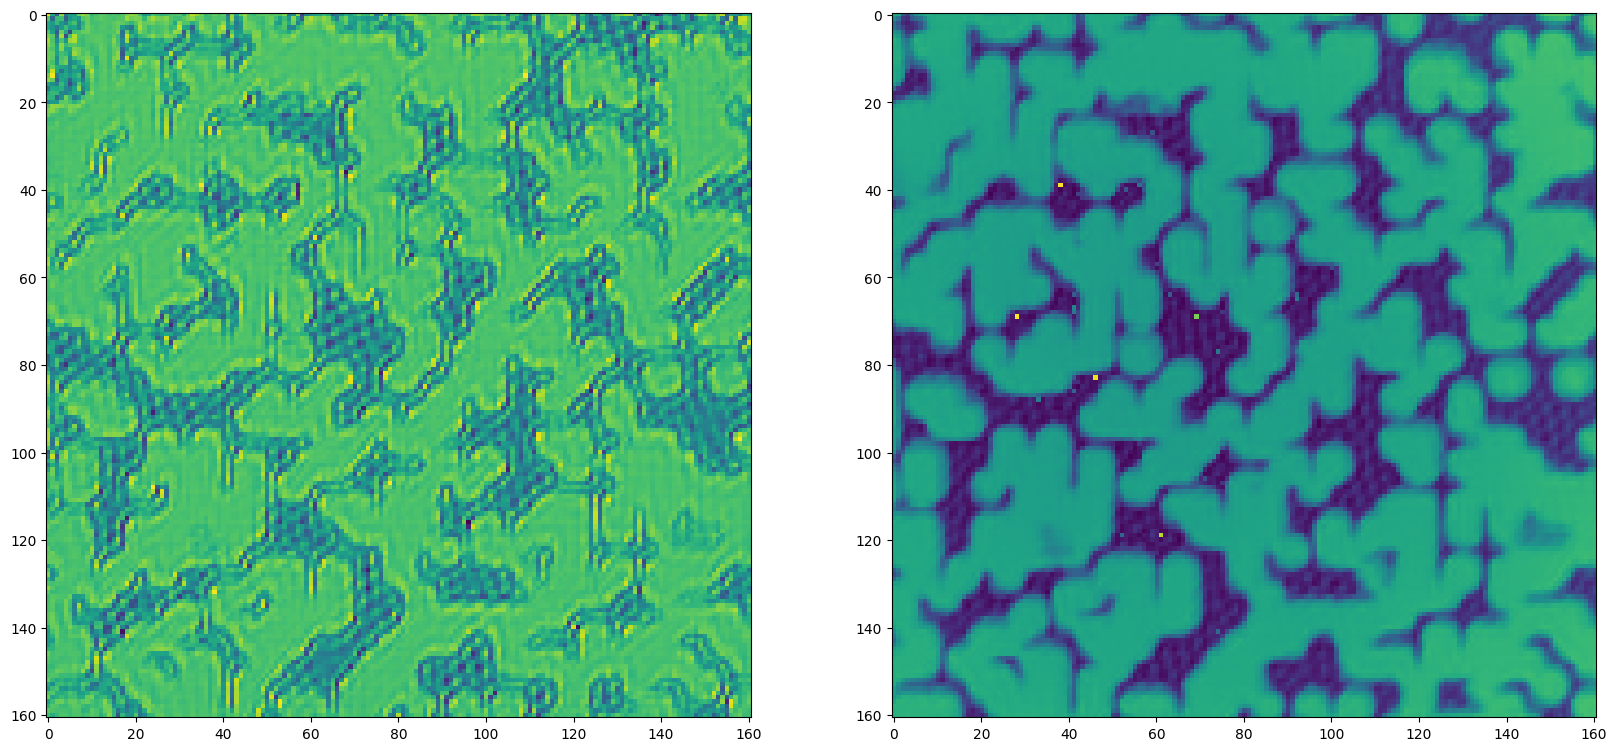

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])